In [1]:
import torch as t
import torch.nn as nn
from torch import einsum
from einops import rearrange, reduce, repeat
import bert_tests

In [2]:
"""
Q = W_Q @ input
K = W_K @ input
V = W_V @ input
attn_pat = normalised_softmax(Q @ K^T)
attention = attn_patn @ V
O = W_O @ attention
"""

'\nQ = W_Q @ input\nK = W_K @ input\nV = W_V @ input\nattn_pat = normalised_softmax(Q @ K^T)\nattention = attn_patn @ V\nO = W_O @ attention\n'

In [3]:
def raw_attention_pattern(token_activations, num_heads, project_query, project_key):
    dk = t.tensor(64) # num heads
    # print(token_activations.shape) # [batch_size, (num_heads), input_length, hidden_size]
    Q = project_query(token_activations) # W_Q: [hidden_size, num_heads * head_size], [batch_size, input_length, num_heads * head_size]
    K = project_key(token_activations)
    # print(project_query, project_key)
    # print(Q.shape, K.shape)
    Q = rearrange(Q, "... n (h s) -> ... h n s", h = num_heads)
    K = rearrange(K, "... n (h s) -> ... h n s", h = num_heads)
    # res = t.einsum('...qc,...kc -> ...kq', Q, K)/t.sqrt(dk)
    res = K.matmul(rearrange(Q, '... q c -> ... c q'))/t.sqrt(dk)
    # print(res.shape)
    return res

bert_tests.test_attention_pattern_fn(raw_attention_pattern)

attention pattern raw MATCH!!!!!!!!
 SHAPE (2, 12, 3, 3) MEAN: 0.01464 STD: 0.1089 VALS [-0.0608 0.1288 -0.03011 -0.07367 0.1024 0.0883 -0.1601 0.03394 -0.2108 0.03387...]


In [4]:
def bert_attention(token_activations, num_heads, attention_pattern, project_value, project_output):
    softmaxed = t.nn.functional.softmax(attention_pattern, dim=-2)
    V = project_value(token_activations)
    V = rearrange(V, "... n (h s) -> ... h n s", h=num_heads)
    #print(V.shape, softmaxed.shape)
    #print((softmaxed @ V).shape)
    res = project_output(rearrange(t.einsum("...htf,...hts->...hfs", softmaxed, V), "... h n s -> ... n (h s)"))
    #print(res.shape)
    return res

bert_tests.test_attention_fn(bert_attention)

attention MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: 0.0002383 STD: 0.1209 VALS [-0.03247 0.1209 -0.2009 0.01448 0.04943 -0.0147 0.2965 0.02802 0.07579 -0.1073...]


In [5]:
class MultiHeadedSelfAttention(t.nn.Module):
    def __init__(self, num_heads, hidden_size):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.pattern = nn.ModuleDict({
            'project_query': nn.Linear(hidden_size, hidden_size),
            'project_key': nn.Linear(hidden_size, hidden_size)
        })
        self.project_value = nn.Linear(hidden_size, hidden_size)
        self.project_out = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        # print(x.shape, self.num_heads, self.hidden_size)
        attn_pattern = raw_attention_pattern(x, self.num_heads, self.pattern['project_query'], self.pattern['project_key'])
        return bert_attention(x, self.num_heads, attn_pattern, self.project_value, self.project_out)



In [6]:
def bert_mlp(token_activations, linear_1, linear_2):
    return linear_2(t.nn.functional.gelu(linear_1(token_activations)))

bert_tests.test_bert_mlp(bert_mlp)

bert mlp MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: 0.0006734 STD: 0.1067 VALS [-0.006726 0.07883 -0.07867 -0.1464 -0.1546 0.00825 0.1647 0.08232 -0.01181 0.02754...]


In [7]:
class BertMLP(nn.Module):
    def __init__(self, input_size: int, intermediate_size: int) -> None:
        super().__init__()
        self.mlp1 = nn.Linear(input_size, intermediate_size)
        self.mlp2 = nn.Linear(intermediate_size, input_size)
        self.layer_norm = LayerNorm(input_size)
    
    def forward(self, x):
        return self.layer_norm(bert_mlp(x, self.mlp1, self.mlp2) + x)

In [8]:
class LayerNorm(nn.Module):
    EPS = 1e-5
    def __init__(self, normalized_dim: int) -> None:
        super().__init__()
        self.weight = nn.Parameter(t.ones(normalized_dim))
        self.bias = nn.Parameter(t.zeros(normalized_dim))
    
    def forward(self, x):
        # print(x.shape)
        x = x - x.mean(dim=-1, keepdim=True).detach()
        x = x/(x.var(dim=-1, unbiased=False, keepdim=True).detach() + self.EPS).sqrt()
        # print(self.weight.shape, self.bias.shape, x.shape)
        # print(self.weight)
        # print(self.bias)
        # print(x)
        # print(t.einsum('...i,i->...i', x, self.weight) + self.bias)
        return t.einsum('...i,i->...i', x, self.weight) + self.bias

bert_tests.test_layer_norm(LayerNorm)

layer norm MATCH!!!!!!!!
 SHAPE (20, 10) MEAN: 0 STD: 1.003 VALS [-0.9841 -0.5669 -0.7758 1.43 -1.739 0.3949 0.09413 0.895 -0.1765 1.429...]


In [9]:
class BertBlock(nn.Module):
    def __init__(self, hidden_size : int, intermediate_size : int, num_heads : int, dropout : float):
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.layer_norm = LayerNorm(hidden_size)
        self.attention = MultiHeadedSelfAttention(num_heads, hidden_size)
        self.residual = BertMLP(hidden_size, intermediate_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        y = self.attention(x)
        y = self.layer_norm(y + x)
        z = self.residual(y)
        z = self.dropout(z)
        return z

bert_tests.test_bert_block(BertBlock)

bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -2.897e-09 STD: 1 VALS [0.007132 -0.04372 0.6502 -0.5972 -1.097 0.7267 0.1275 -0.6035 -0.2226 0.2145...]


In [10]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
print(tokenizer(['Hello, I am a sentence.']))


{'input_ids': [[101, 8667, 117, 146, 1821, 170, 5650, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [11]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.weight = nn.Parameter(t.randn(vocab_size, embed_size))

    def forward(self, input):
        return self.weight[input]

#bert_tests.test_embedding(Embedding)

In [12]:
def bert_embedding(input_ids, token_type_ids, position_embedding, token_embedding, token_type_embedding, layer_norm, dropout):
    embeddings = token_embedding(input_ids)
    embeddings += position_embedding(t.arange(0, input_ids.shape[-1]).to(input_ids.device))
    embeddings += token_type_embedding(token_type_ids)
    return dropout(layer_norm(embeddings))

#bert_tests.test_bert_embedding_fn(bert_embedding)


In [13]:
class BertEmbedding(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_position_embeddings: int, type_vocab_size: int, dropout: float) -> None:
        super().__init__()
        self.token_embedding = Embedding(vocab_size, hidden_size)
        self.position_embedding = Embedding(max_position_embeddings, hidden_size)
        self.token_type_embedding = Embedding(type_vocab_size, hidden_size)
        self.layer_norm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids, token_type_ids):
        return bert_embedding(input_ids, token_type_ids, self.position_embedding, self.token_embedding, self.token_type_embedding, self.layer_norm, self.dropout)

#bert_tests.test_bert_embedding(BertEmbedding)

In [14]:
class Bert(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, 
max_position_embeddings: int, type_vocab_size: int, 
dropout: float, intermediate_size: int, num_heads: int, 
num_layers: int
) -> None:
        super().__init__()
        self.embedding = BertEmbedding(vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout)
        self.transformer = nn.Sequential(
            *[BertBlock(hidden_size, intermediate_size, num_heads, dropout) for _ in range(num_layers)],
        )
        self.lm_head = nn.ModuleDict({
            'mlp': nn.Linear(hidden_size, hidden_size),
            'gelu': nn.GELU(),
            'unembedding': nn.Linear(hidden_size, vocab_size),
            'layer_norm': LayerNorm(hidden_size),
        })
    
    def forward(self, input_ids):
        x = self.embedding(input_ids, t.zeros_like(input_ids))
        x = self.transformer(x)
        x = self.lm_head['mlp'](x)
        x = self.lm_head['gelu'](x)
        x = self.lm_head['layer_norm'](x)
        x = self.lm_head['unembedding'](x)
        return x

# bert_tests.test_bert(Bert)

In [15]:
# my_bert = Bert(
#     vocab_size=28996, hidden_size=768, max_position_embeddings=512, 
#     type_vocab_size=2, dropout=0.1, intermediate_size=3072, 
#     num_heads=12, num_layers=12
# )
pretrained_bert = bert_tests.get_pretrained_bert()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# pretrained_state_dict = pretrained_bert.state_dict()
# del pretrained_state_dict['classification_head.weight']
# del pretrained_state_dict['classification_head.bias']
# my_bert.load_state_dict(pretrained_state_dict)
# bert_tests.test_same_output(my_bert, pretrained_bert)

In [17]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
uncased_tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

encoded = uncased_tokenizer.encode("Hi, my name is bert")
tokenizer.decode(encoded)

'[CLS] colleges 天 largest happened smile donation [SEP]'

In [18]:
def ascii_art_probs(sentence):
    mask_encoding = tokenizer.encode('[MASK]')[1]

    my_bert.eval()

    encoding = t.tensor(tokenizer.encode(sentence))

    logits = my_bert(encoding)[encoding == mask_encoding]

    probs = nn.functional.softmax(logits, dim=-1)
    probs, word_indices = probs.sort(descending=True, dim=-1)

    probs = probs[:, :10]
    word_indices = word_indices[:, :10]

    words = [[tokenizer.decode(word) for word in word_options] for word_options in word_indices]
    if len(words) > 1:
        print("please don't double mask")
    words_with_probs = zip(words[0], probs[0])
    
    sentence_for_display = sentence.replace('[MASK]', '---')
    print(sentence_for_display)
    for word, prob in words_with_probs:
        print(f"%{sentence_for_display.index('---') - 2}.1d%% %s" % (prob * 100, word))
# ascii_art_probs("The fish loves to eat [MASK].")

In [15]:
class CBert(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, 
max_position_embeddings: int, type_vocab_size: int, 
dropout: float, intermediate_size: int, num_heads: int, 
num_layers: int, num_classes : int
) -> None:
        super().__init__()
        self.embedding = BertEmbedding(vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout)
        self.transformer = nn.Sequential(
            *[BertBlock(hidden_size, intermediate_size, num_heads, dropout) for _ in range(num_layers)],
        )
        self.lm_head = nn.ModuleDict({
            'mlp': nn.Linear(hidden_size, hidden_size),
            'gelu': nn.GELU(),
            'unembedding': nn.Linear(hidden_size, vocab_size),
            'layer_norm': LayerNorm(hidden_size),
        })
        self.classification_head = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids):
        x = self.embedding(input_ids, t.zeros_like(input_ids))
        x = self.transformer(x)
        # x = self.lm_head['mlp'](x)
        # x = self.lm_head['gelu'](x)
        # x = self.lm_head['layer_norm'](x)
        # x = self.lm_head['unembedding'](x)
        x = self.classification_head(self.dropout(x))
        x = t.nn.functional.softmax(x, dim=-1)
        return x[:,0,1]

#bert_tests.test_bert(CBert)

In [20]:
# import torchtext
# data_train, data_test = torchtext.datasets.IMDB(
#     root='.data',
#     split=('train', 'test')
# )

In [16]:
"""
x- shuffle
- pad
- truncate
- tokenize
- convert neg/pos to 0/1
- 
"""
import random

def pads_sequences(dataset, max_seq_len, batch_size=64):
    all_data = [data for data in dataset]
    random.shuffle(all_data)

    batched_data = []
    for i in range(0, len(all_data), batch_size):
        batch = all_data[i:min(len(all_data), i+batch_size)]
        classifications, sentences = zip(*batch)

        classifications = [1 if classification == 'pos' else 0 for classification in classifications]
        # print(classifications)
        # print(sentences)
        sentences = tokenizer(list(sentences), padding="longest", max_length=max_seq_len, truncation=True)
        # print(sentences)

        batched_data.append((classifications, sentences))
    return batched_data

# processed_train_data = pads_sequences(data_train, 512, batch_size=32)
# processed_test_data = pads_sequences(data_test, 512, batch_size=32)

In [17]:
from tqdm.notebook import tqdm

def train(model, data_train, data_test, n_iter=500, epochs=1):
    perf_history = []
    test_loss_history = []


    loss_fn = t.nn.BCELoss()
    optimizer = t.optim.Adam(params=model.parameters(), lr=1e-5)

    for _ in range(epochs):
        n = 0
        model.train()
        for batch in tqdm(data_train):
            n += 1
            if n > n_iter:
                break
            print(n)
            optimizer.zero_grad()
            out = model(t.tensor(batch[1]['input_ids']).to('cuda'))
            loss = loss_fn(out, t.tensor(batch[0]).float().to('cuda'))
            loss.backward()

            optimizer.step()
            perf_history.append(loss.detach().clone())


        with t.no_grad():
            model.test()
            test_loss = 0
            for batch in data_test:
                test_out = model(t.tensor(batch[1]['input_ids']).to('cuda'))
                test_loss += loss_fn(test_out, t.tensor(batch[0]).clone().detach().float().to('cuda'))
            test_loss_history.append(test_loss / len(data_test))

    return perf_history, test_loss_history

# cbert = CBert(
#     vocab_size=28996, hidden_size=768, max_position_embeddings=512, 
#     type_vocab_size=2, dropout=0.1, intermediate_size=3072, 
#     num_heads=12, num_layers=12, num_classes=2).to('cuda')
# pretrained_state_dict = pretrained_bert.state_dict()
# cbert.load_state_dict(pretrained_state_dict)
# perf_history, test_loss_history = train(cbert, processed_train_data, processed_test_data)

In [18]:
# import matplotlib.pyplot as plt
# plt.plot(perf_history)
# plt.plot(test_loss_history*len(perf_history))

In [ ]:
# batch = processed_test_data[47]

# input = t.tensor(batch[1]['input_ids']).to('cuda')
# target = batch[0]
# output = cbert(input)



In [ ]:
# out = list(output)
# for i in range(len(out)):
#     correct = (out[i] > 0.5) == (target[i] > 0.5)
#     if not correct:
#         print(f"Predicted: {out[i]} | Target: {target[i]}" + ("" if correct else "   INCORRECT"))
#     if not correct:
#         print(tokenizer.decode(batch[1][i].ids))


Predicted: 0.3053981363773346 | Target: 1   INCORRECT
[CLS] If all movies had to be destroyed and only one could be spared, Death in Venice would have to be it. It is a monument in movie history. Much criticized for being slow, boring and too obvious in stating it's point ( an old man discovers beauty in a young boy and is tragically destroyed, first mentally, then physically ), we should appreciate this movie for what it is.'Morte a Venezia'was shot over 30 years ago, and it portrays a period even further back, at the beginning of the twentieth century. < br / > < br / > Life was slow then, compared to now. People were supposed to behave in a certain way, hiding their true emotions even from themselves. Director Visconti and Dirk Bogarde, the leading actor, admirably succeed in showing how the aging composer Von Aschenbach discovers his romantic interest in a young boy. For a man like Von Aschenbach, in his time, this must have been a shock too powerful to come to terms with. We see h

In [ ]:
print(tokenizer.decode([1, 6, 5]))

[unused1] [unused6] [unused5]


In [ ]:
stde = pretrained_bert.embedding.token_embedding.weight.std(dim=0)

In [ ]:
stdue = pretrained_bert.lm_head.unembedding.weight.std(dim=0)

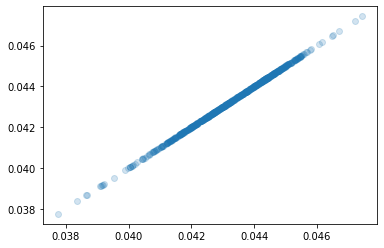

In [ ]:
plt.scatter(stde.clone().detach(), stdue.clone().detach(), alpha=0.2)

In [ ]:
(std - stdue).sum()

tensor(0., grad_fn=<SumBackward0>)

In [ ]:
cbert = t.load('cbert.pkl')

AttributeError: Can't get attribute 'CBert' on <module '__main__'>

# Training from scratch

In [35]:

import random
import torchtext

def pads_sequences(dataset, max_seq_len, batch_size=64):
    all_data = [data for data in dataset]
    random.shuffle(all_data)

    batched_data = []
    for i in range(0, len(all_data), batch_size):
        batch = all_data[i:min(len(all_data), i+batch_size)]

        sentences = tokenizer(list(batch), padding="longest", max_length=max_seq_len, truncation=True)

        batched_data.append( sentences['input_ids'])
    return batched_data

data_train, data_valid, data_test = torchtext.datasets.WikiText2()

processed_train_data = pads_sequences(data_train, 512, batch_size=32)
processed_test_data = pads_sequences(data_valid, 512, batch_size=32)
processed_valid_data = pads_sequences(data_test, 512, batch_size=32)

processed_train_data = [t.tensor(batch) for batch in processed_train_data]
processed_test_data = [t.tensor(batch) for batch in processed_test_data]
processed_valid_data = [t.tensor(batch) for batch in processed_valid_data]

In [36]:


dist = t.distributions.Bernoulli(0.15)
mask_token = tokenizer.encode('[MASK]')[1]
pad_token = tokenizer.encode('[PAD]')[1]

def mask(example):
    samples = dist.sample(example.shape).bool()
    samples[example == pad_token] = False
    correct_results = example.clone()
    example[..., samples] = mask_token
    return example, correct_results


masked_train_data = [mask(batch) for batch in processed_train_data]
masked_test_data = [mask(batch) for batch in processed_test_data]
masked_valid_data = [mask(batch) for batch in processed_valid_data]

In [37]:
import cProfile

In [38]:
from tqdm.notebook import tqdm

def train(model, data_train, data_test, n_iter=None, epochs=3):
    perf_history = []
    test_loss_history = []


    loss_fn = t.nn.CrossEntropyLoss() # changeme
    optimizer = t.optim.Adam(params=model.parameters(), lr=1e-3)

    for _ in range(epochs):
        n = 0
        model.train()
        for batch in tqdm(data_train):
            n += 1
            if n_iter is not None and n > n_iter:
                break
            optimizer.zero_grad()
            input = batch[0].to('cuda')
            correct_results = batch[1].to('cuda')
            
            out = model(input)
            masked_positions = (input == mask_token)

            masked_out = out.to('cuda').masked_select(masked_positions.unsqueeze(-1).to('cuda'))
            correct_results = correct_results.masked_select(masked_positions.to('cuda'))
            masked_out = masked_out.reshape((correct_results.shape[0], out.shape[-1]))

            loss = loss_fn(masked_out, correct_results)
            loss.backward()
            optimizer.step()
            perf_history.append(loss.detach().clone())
            print('train loss:', perf_history[-1])

        with t.no_grad():
            model.test()
            test_loss = 0
            for batch in data_test:
                input = t.tensor(batch[0]).to('cuda')
                test_out = model(input)
                masked_positions = input == mask_token
                masked_out = test_out[masked_positions,:]
                test_loss += loss_fn(masked_out, t.tensor(batch[0]).clone().detach().float().to('cuda'))
            test_loss_history.append(test_loss / len(data_test))

    return perf_history, test_loss_history

tiny_bert = Bert(
    vocab_size=28996, hidden_size=384, max_position_embeddings=512, 
    type_vocab_size=2, dropout=0.1, intermediate_size=1536, 
    num_heads=12, num_layers=2
)
perf_history, test_loss_history = train(tiny_bert, masked_train_data, masked_test_data)
t.save(tiny_bert, 'tiny_bert_3epochs.pkl')

  0%|          | 0/1148 [00:00<?, ?it/s]

train loss: tensor(10.4522, device='cuda:0')
train loss: tensor(9.8628, device='cuda:0')
train loss: tensor(9.5307, device='cuda:0')
train loss: tensor(9.2347, device='cuda:0')
train loss: tensor(9.0300, device='cuda:0')
train loss: tensor(8.7935, device='cuda:0')
train loss: tensor(8.3899, device='cuda:0')
train loss: tensor(8.1531, device='cuda:0')
train loss: tensor(7.9743, device='cuda:0')
train loss: tensor(7.7833, device='cuda:0')
train loss: tensor(7.8750, device='cuda:0')
train loss: tensor(7.7391, device='cuda:0')
train loss: tensor(7.3487, device='cuda:0')
train loss: tensor(7.6247, device='cuda:0')
train loss: tensor(7.2639, device='cuda:0')
train loss: tensor(7.7294, device='cuda:0')
train loss: tensor(6.9170, device='cuda:0')
train loss: tensor(8.1456, device='cuda:0')
train loss: tensor(7.9316, device='cuda:0')
train loss: tensor(8.0964, device='cuda:0')
train loss: tensor(7.5393, device='cuda:0')
train loss: tensor(7.4387, device='cuda:0')
train loss: tensor(7.4651, devi

In [40]:
def ascii_art_probs2(sentence):
    mask_encoding = tokenizer.encode('[MASK]')[1]

    tiny_bert.eval()

    encoding = t.tensor(tokenizer.encode(sentence))

    logits = tiny_bert(encoding)[encoding == mask_encoding]

    probs = nn.functional.softmax(logits, dim=-1)
    probs, word_indices = probs.sort(descending=True, dim=-1)

    probs = probs[:, :10]
    word_indices = word_indices[:, :10]

    words = [[tokenizer.decode(word) for word in word_options] for word_options in word_indices]
    if len(words) > 1:
        print("please don't double mask")
    words_with_probs = zip(words[0], probs[0])
    
    sentence_for_display = sentence.replace('[MASK]', '---')
    print(sentence_for_display)
    for word, prob in words_with_probs:
        print(f"%{sentence_for_display.index('---') - 2}.1d%% %s" % (prob * 100, word))
# ascii_art_probs("The fish loves to eat [MASK].")

In [44]:
ascii_art_probs2("Hi, my name is [MASK].")

Hi, my name is ---.
            4% the
            2% .
            2% >
            2% of
            2% un
            2% <
            2% ,
            1% a
            1% @
            1% and


In [47]:
t.save(tiny_bert, 'tiny_bert_400.pkl')